In [2]:
import pandas as pd 
# default='warn', Used here to supress warning when slicing and creating high earners column
pd.options.mode.chained_assignment = None 


In [3]:
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [4]:
# custom function from Web_scrapper_League_Tables notebook 
from ipynb.fs.full.Web_scrapper_League_Tables import League_table_scraper

#### Getting data from the API

In [5]:
API_key='d15f7132973d404d9d046934398ee9e3'

In [6]:
# API authorization
headers = {'x-api-key':'d15f7132973d404d9d046934398ee9e3', 'accept': 'application/json', 'accept': 'text/csv'}

# Choose endpoint
endpoint = 'https://www.capology.com/api/v2/soccer/salaries/br/brasileiro/2020/'

# Retrieve json
json1 = requests.get(endpoint, headers=headers).text

#Data for 2020
df1 = pd.read_json(json1)

#Capology has defined the seson as winter,combined
df1 = df1[df1["season_term"] == "combined"].reset_index(drop = True)

In [7]:
# API authorization
headers = {'x-api-key':'d15f7132973d404d9d046934398ee9e3', 'accept': 'application/json', 'accept': 'text/csv'}

# Choose endpoint
endpoint = 'https://www.capology.com/api/v2/soccer/salaries/br/brasileiro/2021/'

# Retrieve json
json2 = requests.get(endpoint, headers=headers).text

#Data for 2021
df2 = pd.read_json(json2)

df2 = df2[df2["season_term"] == "summer"]

In [8]:
# API authorization
headers = {'x-api-key':'d15f7132973d404d9d046934398ee9e3', 'accept': 'application/json', 'accept': 'text/csv'}

# Choose endpoint
endpoint = 'https://www.capology.com/api/v2/soccer/salaries/br/brasileiro/2022/'

# Retrieve json
json3 = requests.get(endpoint, headers=headers).text

#Data for 2022
df3 = pd.read_json(json3)

df3 = df3[df3["season_term"] == "summer"]

In [9]:
df = pd.concat([df1,df3,df2],axis=0).drop_duplicates()


#### Cleaning Data frame

In [10]:
df = df[df['salary_gross_eur'] != 0]

In [11]:
df.head()

,season_id,season_term,league_name,league_id,country_id,club_name,club_id,club_code,player_name,player_id,...,salary_gross_gbp,salary_net_gbp,salary_gross_usd,salary_net_usd,adjusted_gross_eur,adjusted_net_eur,adjusted_gross_gbp,adjusted_net_gbp,adjusted_gross_usd,adjusted_net_usd
0,2020,combined,Brasileiro,brasileiro,br,Athletico Paranaense,athletico-paranaense,CAP,Abner,abner-36673,...,49872,33248,60000,40000,59121,39414,52215,34810,62819,41879
1,2020,combined,Brasileiro,brasileiro,br,Athletico Paranaense,athletico-paranaense,CAP,Anderson Paixão,anderson-paixao-35859,...,66497,49872,80000,60000,78828,59121,69620,52215,83758,62819
2,2020,combined,Brasileiro,brasileiro,br,Athletico Paranaense,athletico-paranaense,CAP,Bento,bento-36321,...,24936,16624,30000,20000,29561,19707,26108,17405,31409,20940
3,2020,combined,Brasileiro,brasileiro,br,Athletico Paranaense,athletico-paranaense,CAP,Bruno Leite,bruno-leite-36623,...,49872,33248,60000,40000,59121,39414,52215,34810,62819,41879
4,2020,combined,Brasileiro,brasileiro,br,Athletico Paranaense,athletico-paranaense,CAP,Caio,caio-35456,...,74809,58184,90000,70000,88682,68975,78323,60918,94228,73289


In [12]:
#Required columns
LIST = ['season_id','club_code','player_age','player_country_id','player_group_code','salary_gross_eur']

In [13]:
df_salary = df[LIST]

In [14]:
df_salary.head()

,season_id,club_code,player_age,player_country_id,player_group_code,salary_gross_eur
0,2020,CAP,20,brazil,D,56469
1,2020,CAP,22,brazil,K,75291
2,2020,CAP,21,brazil,K,28234
3,2020,CAP,20,brazil,F,56469
4,2020,CAP,23,brazil,K,84703


#### Finding High Earners

In [15]:
# Group the data by 'club' and 'position'
groups = df_salary.groupby(['club_code', 'player_group_code','season_id'])
# Find the highest two values of column 'salary_gross_eur' for each group
top_two = groups['salary_gross_eur'].nlargest(2).reset_index()

# get needed indexes
index = list(top_two['level_3'])

# Add the result to the data frame as a new column
df_salary['high_earner'] = 0
for i in index:
    df_salary.loc[i, 'high_earner'] = 1

In [16]:
df_salary.head()

,season_id,club_code,player_age,player_country_id,player_group_code,salary_gross_eur,high_earner
0,2020,CAP,20,brazil,D,56469,0
1,2020,CAP,22,brazil,K,75291,0
2,2020,CAP,21,brazil,K,28234,0
3,2020,CAP,20,brazil,F,56469,0
4,2020,CAP,23,brazil,K,84703,0


#### Creating  needed features

In [17]:
CODE_DICT=pd.Series(df.club_code.values,index=df.club_name).to_dict()

In [18]:
df_salary.player_country_id.unique()

array(['brazil', 'colombia', 'uruguay', 'argentina', 'ecuador',
       'venezuela', 'paraguay', 'peru', 'japan', 'cote-d-ivoire', 'chile',
       'south-korea', 'bolivia', 'italy', 'united-states', 'spain',
       'china', 'ukraine', 'finland', 'portugal', 'belarus'], dtype=object)

In [19]:
def set_region(row):
    """
    Function takes each row as argument and returns the region 
    based on the player_country_id.
    """
    
    south_america = {'uruguay', 'colombia', 'argentina', 'ecuador','chile', 'venezuela', 'paraguay','peru','bolivia'}
    europe = {'spain','italy','belarus','portugal','finland','ukraine','finland'}
    rest_of_world = {'south-korea','united-states','china','japan','cote-d-ivoire'}
    
    if row['player_country_id'] in south_america:
        return 'south america'
    
    elif row['player_country_id'] in europe:
        return 'europe'
    
    elif row['player_country_id'] in rest_of_world:
        return 'rest of the world'
    
    else:
        return 'brazil'

In [20]:
CODE_DICT

{'Athletico Paranaense': 'CAP',
 'Atletico Mineiro': 'CAM',
 'Botafogo': 'BOT',
 'Ceara Sporting Club': 'CEA',
 'Corinthians': 'CRS',
 'Coritiba': 'CRB',
 'Esporte Clube Bahia': 'ECB',
 'Flamengo': 'FLA',
 'Fluminense': 'FLU',
 'Fortaleza': 'FOR',
 'Goianiense': 'GOE',
 'Goias': 'GOI',
 'Gremio': 'GRM',
 'Internacional': 'INR',
 'Palmeiras': 'PLM',
 'Red Bull Bragantino': 'RED',
 'Santos': 'SAN',
 'Sao Paulo': 'SAP',
 'Sport Club do Recife': 'SCR',
 'Vasco da Gama': 'VAS',
 'America FC': 'AMG',
 'Avai': 'AVI',
 'Cuiaba': 'CUI',
 'Juventude': 'JUD',
 'Chapecoense': 'CPE'}

In [21]:
# Update dictonary by running the map function and checking the mising keys 
CODE_DICT['Grêmio'] = 'GRM'
CODE_DICT['São Paulo'] = 'SAP'
CODE_DICT['Goiás'] = 'GOI'
CODE_DICT['Bahia'] = 'ECB'
CODE_DICT['Ceará'] ='CEA'
CODE_DICT['Atlético Mineiro'] ='CAM'
CODE_DICT['Atlético Goianiense'] ='GOE'
CODE_DICT['Sport'] = 'SCR'
CODE_DICT['América Mineiro'] = 'AMG'
CODE_DICT['Cuiabá'] = 'CUI'
CODE_DICT['Avaí'] = 'AVI'

In [22]:
# Final league standings 2020
standings_2020 = League_table_scraper('https://en.wikipedia.org/wiki/2020_Campeonato_Brasileiro_S%C3%A9rie_A',9)
standings_2020 = list(map(lambda x: CODE_DICT[x], standings_2020.club))

# Final league standings 2021
standings_2021 = League_table_scraper('https://en.wikipedia.org/wiki/2021_Campeonato_Brasileiro_S%C3%A9rie_A',9)
standings_2021 = list(map(lambda x: CODE_DICT[x], standings_2021.club))

# Final league standings 2022
standings_2022 = League_table_scraper('https://en.wikipedia.org/wiki/2022_Campeonato_Brasileiro_S%C3%A9rie_A',9)
standings_2022 = list(map(lambda x: CODE_DICT[x], standings_2022.club))

In [23]:
def set_club_type(row):
    
    """
    Function takes each row as argument and returns
    top 6,6-10,mid-table, relagation based on the club 
    finishing position for the year
    
    """
    if (row['club_code'] in standings_2020[:6] and row['season_id']==2020) or (row['club_code'] in standings_2021[0:6] and row['season_id']==2021) or (row['club_code'] in standings_2022[0:6] and row['season_id']==2022):
        return 'top 6'
   
    elif (row['club_code'] in standings_2020[6:11] and row['season_id']==2020) or (row['club_code'] in standings_2021[6:11] and row['season_id']==2021) or (row['club_code'] in standings_2022[6:11] and row['season_id']==2022):
        return '6-10'
    
    elif (row['club_code'] in standings_2020[11:16] and row['season_id']==2020) or (row['club_code'] in standings_2021[11:16] and row['season_id']==2021) or (row['club_code'] in standings_2022[11:16] and row['season_id']==2022):
        return 'mid-table'
    
    else :
        return 'relegation'


In [24]:
X = df_salary[['club_code', 'player_age', 'player_country_id', 'player_group_code','season_id','high_earner']]

X = X.assign(Age=pd.cut(X['player_age'], 
                               bins=[0, 17, 21,23, 27, 32,99], 
                               labels=['U18', '18-21', '21-23','23-27','27-32','32+']))

X = X.assign(region=X.apply(set_region, axis=1)).astype('category')

X = X.assign(club_level=X.apply(set_club_type,axis=1)).astype('category')

X = X.drop('player_country_id',axis=1)
X = X.drop('player_age',axis=1)
X = X.drop('season_id',axis=1)

In [25]:
X.head()

,club_code,player_group_code,high_earner,Age,region,club_level
0,CAP,D,0,18-21,brazil,6-10
1,CAP,K,0,21-23,brazil,6-10
2,CAP,K,0,18-21,brazil,6-10
3,CAP,F,0,18-21,brazil,6-10
4,CAP,K,0,21-23,brazil,6-10


#### Preapring data frame for modelling


In [26]:
X = pd.get_dummies(data=X, drop_first = True)

In [27]:
set(df.club_code.values)

{'AMG',
 'AVI',
 'BOT',
 'CAM',
 'CAP',
 'CEA',
 'CPE',
 'CRB',
 'CRS',
 'CUI',
 'ECB',
 'FLA',
 'FLU',
 'FOR',
 'GOE',
 'GOI',
 'GRM',
 'INR',
 'JUD',
 'PLM',
 'RED',
 'SAN',
 'SAP',
 'SCR',
 'VAS'}

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2202 entries, 0 to 2266
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   club_code_AVI             2202 non-null   uint8
 1   club_code_BOT             2202 non-null   uint8
 2   club_code_CAM             2202 non-null   uint8
 3   club_code_CAP             2202 non-null   uint8
 4   club_code_CEA             2202 non-null   uint8
 5   club_code_CPE             2202 non-null   uint8
 6   club_code_CRB             2202 non-null   uint8
 7   club_code_CRS             2202 non-null   uint8
 8   club_code_CUI             2202 non-null   uint8
 9   club_code_ECB             2202 non-null   uint8
 10  club_code_FLA             2202 non-null   uint8
 11  club_code_FLU             2202 non-null   uint8
 12  club_code_FOR             2202 non-null   uint8
 13  club_code_GOE             2202 non-null   uint8
 14  club_code_GOI             2202 non-null 

In [29]:
Y = np.log(df_salary['salary_gross_eur'])

#### Fiiting the Model

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=100)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1321, 39)
(881, 39)
(1321,)
(881,)


In [31]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [32]:
X_test.to_csv(r'C:\Users\Ramya\X_test_br.csv')

In [33]:
print(model.intercept_)

9.662763547138853


In [34]:
coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns = ['Coefficient']).reset_index()
coeff_parameter

,index,Coefficient
0,club_code_AVI,-0.716274
1,club_code_BOT,0.667919
2,club_code_CAM,1.315480
3,club_code_CAP,0.653790
4,club_code_CEA,-0.206800
5,club_code_CPE,-0.370237
6,club_code_CRB,0.159788
7,club_code_CRS,1.486823
8,club_code_CUI,-0.115081
9,club_code_ECB,0.415202


#### Model Evaluation

In [35]:
predictions = model.predict(X_test)
predictions

array([11.3990608 , 12.68323076, 11.02520783, 13.24518688, 12.48531218,
       13.68148109, 10.77824075, 12.36821477, 11.72827046, 11.95361209,
       14.25817623, 12.30977649, 11.12271499, 11.64751349, 12.02519255,
       11.53599821, 12.92463187, 14.72235162, 14.04100521, 13.83605055,
       11.86040069, 13.0483695 , 14.58951567, 12.50699892, 11.57634417,
       13.81759913, 13.62822986, 12.23199262, 12.36611525, 13.10736373,
       11.56210447, 11.70236832, 11.12271499, 11.26250963, 13.22992173,
       14.0329156 , 12.49803788, 11.70236832, 11.86586218, 11.07575098,
        9.87102179, 11.53903562, 11.18143113, 10.18326459, 12.58659753,
       11.61160927, 12.31389695, 11.11525642, 13.90780837, 11.74990382,
       14.36366654, 11.89301964, 13.14430061, 12.63123232, 10.18326459,
       10.9888098 , 13.28646136, 12.43107759, 10.69447334, 11.65537811,
       12.85584389, 12.23715881, 10.82747262, 12.78008496, 13.20165314,
       10.23558315, 12.88371275, 10.18326459, 12.66411608, 10.23

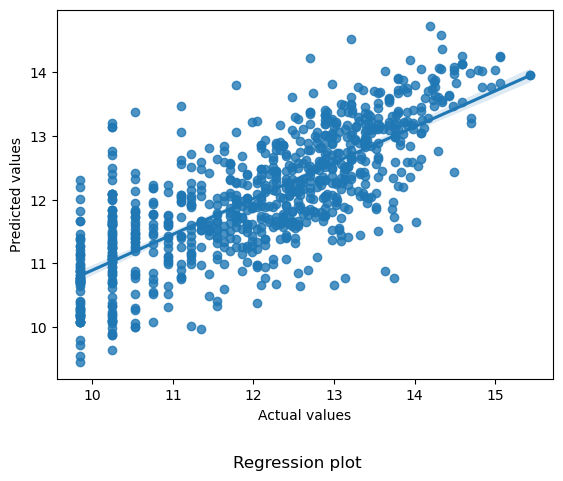

In [52]:
# Generate a regplot plot using Seaborn
sns.regplot(y_test, predictions)

# Add axis labels and a plot title using matplotlib
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.suptitle('Regression plot', y=-0.05)

# Show the plot
#plt.show()

plt.savefig('regression_plot.png', transparent=True)

In [37]:
import statsmodels.api as sm
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:       salary_gross_eur   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     49.29
Date:                Thu, 05 Jan 2023   Prob (F-statistic):          3.46e-224
Time:                        10:38:05   Log-Likelihood:                -1619.0
No. Observations:                1321   AIC:                             3318.
Df Residuals:                    1281   BIC:                             3526.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

C:\Users\Ramya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


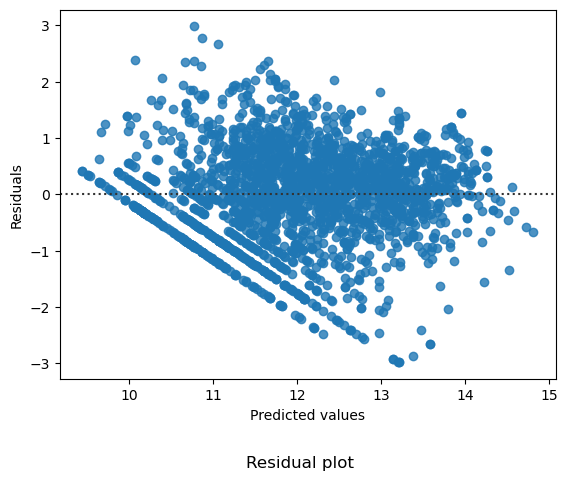

In [50]:
# Generate a residplot plot using Seaborn
sns.residplot(model.predict(X), Y)

# Add axis labels and a plot title using matplotlib
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.suptitle('Residual plot',y=-0.05)

# Show the plot
#plt.show()

plt.savefig('residual_plot.png', transparent=True)

#### Model Export

In [39]:
import pickle
pickle.dump(model, open('model_br.pkl','wb')) 